In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [12]:
# Import necessary libraries
import torch
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# Import metrics from sklearn
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, confusion_matrix)

In [13]:
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

True Tesla T4
Using device: cuda


In [14]:
# DataLoader
def load_data_with_validation_split(train_path, test_path, batch_size=32,
                                      val_split=0.2, img_size=224, num_workers=2):
    # Define transforms
    train_transform = transforms.Compose([
        #transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop(
        img_size,  # Output size (224)
        scale=(0.8, 1.0),  # Randomly scale between 80% and 100% of original
        ratio=(0.9, 1.1)   # Aspect ratio range
    ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load full training dataset w/o augmentation first
    base_trainset = ImageFolder(root=train_path)

    # Split training directiory into train and validation sets
    train_size = int((1 - val_split) * len(base_trainset))
    val_size = len(base_trainset) - train_size

    # split to get indices for train and val with the actual transforms applied later
    train_set, val_set = random_split(base_trainset, [train_size, val_size],
                                     generator=torch.Generator().manual_seed(42))

    # New ImageFolder datasets for train and val with transforms
    train_data = ImageFolder(root=train_path, transform=train_transform)
    val_data = ImageFolder(root=train_path, transform=test_transform)

    # Create subsets using the indices from the split

    trainset = Subset(train_data, train_set.indices)
    valset = Subset(val_data, val_set.indices)

    # Load test dataset
    testset = ImageFolder(root=test_path, transform=test_transform)

    # Create dataloaders
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    classes = base_trainset.classes

    print(f'Classes: {classes}')
    print(f'Training samples: {len(trainset)}')
    print(f'Validation samples: {len(valset)}')
    print(f'Testing samples: {len(testset)}')

    return trainloader, valloader, testloader, classes

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 4569
Validation samples: 1143
Testing samples: 1311


In [25]:
import os

train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

trainloader, valloader, testloader, classes = load_data_with_validation_split(
    train_path, test_path, batch_size=32, val_split=0.2
)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 4569
Validation samples: 1143
Testing samples: 1311


In [15]:
num_classes = len(classes)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)


# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Train only FC
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [22]:
# Evaluation Functions
def calculate_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    specificities = []

    for i in range(num_classes):
        # True Negatives: sum of all cells except row i and column i
        tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        # False Positives: sum of column i except diagonal
        fp = np.sum(cm[:, i]) - cm[i, i]

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)

    return specificities

def evaluate_model(model, dataloader, classes, dataset_name="Test"):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            images = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Move back to CPU for sklearn
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    specificity = calculate_specificity(all_labels, all_preds, len(classes))

    precision_avg = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_avg = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_avg = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    specificity_avg = np.mean(specificity)

# Print results
    print(f"\n{'='*70}")
    print(f"{dataset_name} Set Evaluation")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {accuracy*100:.2f}%\n")

    print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Specificity':<10}")
    print(f"{'-'*70}")

    # Calculate per-class accuracy
    for i, class_name in enumerate(classes):
        class_mask = all_labels == i
        class_accuracy = np.sum((all_preds == all_labels) & class_mask) / np.sum(class_mask) if np.sum(class_mask) > 0 else 0

        print(f"{class_name:<15} {class_accuracy*100:>8.2f}% {precision[i]*100:>9.2f}% "
              f"{recall[i]*100:>9.2f}% {f1[i]*100:>9.2f}% {specificity[i]*100:>9.2f}%")

    print(f"{'-'*70}")
    print(f"{'Weighted Avg':<15} {accuracy*100:>8.2f}% {precision_avg*100:>9.2f}% "
          f"{recall_avg*100:>9.2f}% {f1_avg*100:>9.2f}% {specificity_avg*100:>9.2f}%")
    print(f"{'='*70}\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(f"{'':>15}", end='')
    for class_name in classes:
        print(f"{class_name:<15}", end='')
    print()
    for i, class_name in enumerate(classes):
        print(f"{class_name:>15}", end='')
        for j in range(len(classes)):
            print(f"{cm[i, j]:<15}", end='')
        print()
    print()

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'precision_avg': precision_avg,
        'recall_avg': recall_avg,
        'f1_avg': f1_avg,
        'specificity_avg': specificity_avg,
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

    return metrics

In [17]:
def train_model(model, trainloader, valloader, classes,
                num_epochs=5, lr=0.001, momentum=0.9, save_path='./resnet1fc.pth'):

    # Freeze all layers except FC
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Move model to GPU/CPU
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, data in enumerate(trainloader, 0):

            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        train_loss = running_loss / len(trainloader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data in valloader:
                images = data[0].to(device)
                labels = data[1].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(valloader)

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'  Training    Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
        print(f'  Validation  Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved! (Val Acc: {val_acc:.2f}%)')
        print()

    print('Finished Training')
    print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
    print(f'Model saved to {save_path}')

    return history

def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot accuracy
    ax1.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [18]:
# Train the model
print("Starting training...")
history = train_model(model, trainloader, valloader, classes,
                      num_epochs=50, lr=0.001, momentum=0.9)

Starting training...

Epoch 1/50:
  Training    Loss: 0.7904, Accuracy: 73.50%
  Validation  Loss: 0.5456, Accuracy: 83.46%
Best model saved! (Val Acc: 83.46%)


Epoch 2/50:
  Training    Loss: 0.5163, Accuracy: 82.23%
  Validation  Loss: 0.4406, Accuracy: 86.09%
Best model saved! (Val Acc: 86.09%)


Epoch 3/50:
  Training    Loss: 0.4581, Accuracy: 84.02%
  Validation  Loss: 0.3893, Accuracy: 88.19%
Best model saved! (Val Acc: 88.19%)


Epoch 4/50:
  Training    Loss: 0.4307, Accuracy: 84.81%
  Validation  Loss: 0.3969, Accuracy: 85.91%


Epoch 5/50:
  Training    Loss: 0.4158, Accuracy: 85.55%
  Validation  Loss: 0.3549, Accuracy: 88.63%
Best model saved! (Val Acc: 88.63%)


Epoch 6/50:
  Training    Loss: 0.4015, Accuracy: 86.04%
  Validation  Loss: 0.3585, Accuracy: 87.23%


Epoch 7/50:
  Training    Loss: 0.3889, Accuracy: 86.30%
  Validation  Loss: 0.3459, Accuracy: 88.36%


Epoch 8/50:
  Training    Loss: 0.3661, Accuracy: 87.68%
  Validation  Loss: 0.3334, Accuracy: 89.06%
Best

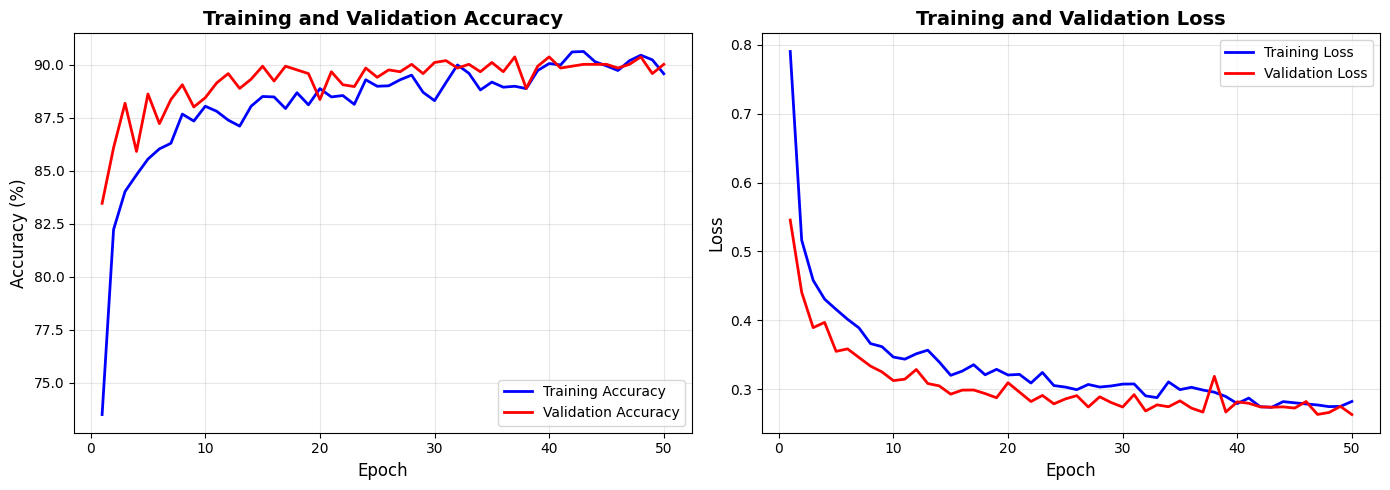

In [19]:
# Plot training history
plot_training_history(history)


In [23]:
# Evaluate on validation set
val_metrics = evaluate_model(model, valloader, classes, dataset_name="Validation")



Validation Set Evaluation
Overall Accuracy: 90.03%

Class           Accuracy   Precision  Recall     F1-Score   Specificity
----------------------------------------------------------------------
glioma             90.74%     85.07%     90.74%     87.81%     95.07%
meningioma         78.71%     82.80%     78.71%     80.70%     95.11%
notumor            95.61%     95.02%     95.61%     95.31%     98.06%
pituitary          93.47%     95.77%     93.47%     94.61%     98.59%
----------------------------------------------------------------------
Weighted Avg       90.03%     90.05%     90.03%     90.00%     96.71%

Confusion Matrix:
               glioma         meningioma     notumor        pituitary      
         glioma245            24             0              1              
     meningioma33             207            12             11             
        notumor6              8              305            0              
      pituitary4              11             4              

In [24]:
# Evaluate on test set (unseen data)
test_metrics = evaluate_model(model, testloader,classes, dataset_name="Test")



Test Set Evaluation
Overall Accuracy: 89.24%

Class           Accuracy   Precision  Recall     F1-Score   Specificity
----------------------------------------------------------------------
glioma             89.67%     89.67%     89.67%     89.67%     96.93%
meningioma         75.82%     81.69%     75.82%     78.64%     94.83%
notumor            95.56%     90.42%     95.56%     92.92%     95.47%
pituitary          94.00%     94.31%     94.00%     94.16%     98.32%
----------------------------------------------------------------------
Weighted Avg       89.24%     89.10%     89.24%     89.13%     96.39%

Confusion Matrix:
               glioma         meningioma     notumor        pituitary      
         glioma269            28             1              2              
     meningioma20             232            39             15             
        notumor8              10             387            0              
      pituitary3              14             1              282   